Training Q-Learning agent on CliffWalking-v0


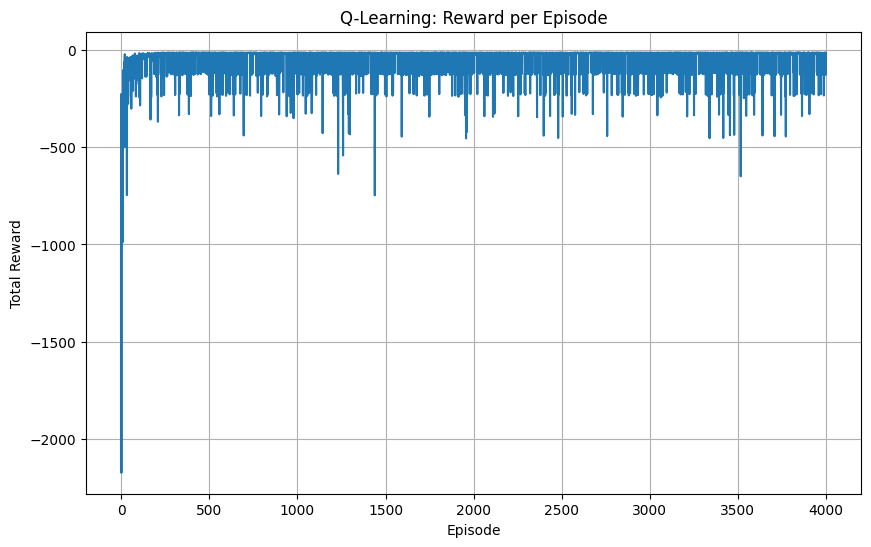

Training SARSA agent on CliffWalking-v0
Q-table:
[[ -11.41630773  -10.78709356  -11.82080524  -11.33353816]
 [ -10.84595154  -10.35372942  -10.6873617   -11.37086802]
 [ -10.27403055   -9.79365848  -10.25568309  -10.90919611]
 [  -9.71698766   -9.18655709   -9.62167745  -10.42308416]
 [  -9.28007905   -8.64945373   -8.98882684   -9.83263066]
 [  -8.4612024    -7.96546045   -8.25824515   -9.28782246]
 [  -7.97533109   -7.24974101   -7.50088259   -8.60198241]
 [  -7.15685787   -6.53352064   -7.0483662    -8.07750648]
 [  -6.68276698   -5.80061822   -6.08494816   -7.28680765]
 [  -5.62372094   -5.00028764   -5.26040757   -6.45092404]
 [  -4.8507217    -4.12166373   -4.45480214   -5.80016229]
 [  -4.02318978   -3.9831244    -3.25385446   -4.96479023]
 [ -11.30710129  -11.56649846  -12.41392231  -11.7613889 ]
 [ -10.93010982  -10.08800299  -20.34028567  -11.61829304]
 [ -10.39035877   -9.70532167  -10.9480652   -10.81501627]
 [  -9.72831104   -9.18792843  -10.03904746  -10.2278099 ]
 [  -9.

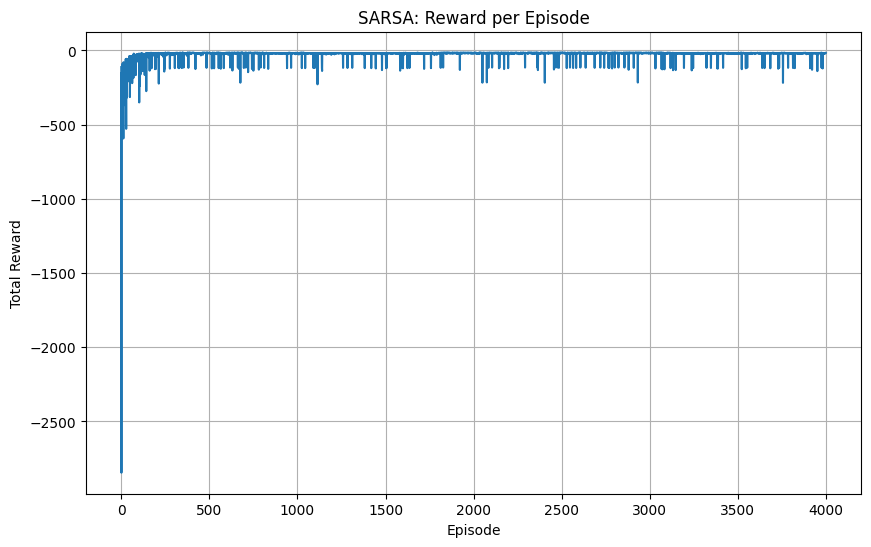


Generating Q-Learning GIF:
GIF saved to images/q_learning_cliffwalker.gif (reward: -13.0, steps: 13)


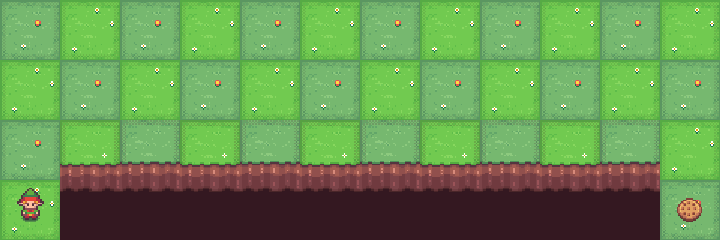


Generating SARSA GIF:
GIF saved to images/sarsa_cliffwalker.gif (reward: -17.0, steps: 17)


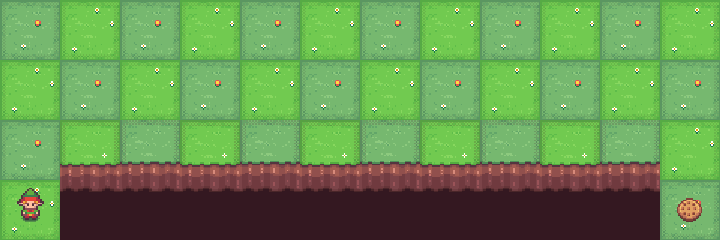

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from PIL import Image
import os
from IPython.display import display, Image as IPImage

# Reference to the original CliffWalking environment:
# https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/cliffwalking.py

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table with zeros
        # For CliffWalking, we'll use a flat state space
        # See how they map from 2d to state 1d state index here: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/cliffwalking.py#L106
        self.q_table = np.zeros((state_size, action_size))

    def select_action(self, state, epsilon=None):
        # epsilon greedy
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.random() < epsilon:
            return np.random.randint(0, self.action_size)
        else:
            return np.argmax(self.q_table[state])

    def update_q_value(self, state, action, reward, next_state):
        # Q-learning use the max (best) policy (not always the one we take. (off-policy)
        self.q_table[state][action] = self.q_table[state][action] + self.alpha * (
            reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state][action]
        )


class SarsaAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))

    def select_action(self, state, epsilon=None):
        # epsilon greedy
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.random() < epsilon:
            return np.random.randint(0, self.action_size)
        else:
            return np.argmax(self.q_table[state])

    def update_q_value(self, state, action, reward, next_state, next_action):
        # SARSA update formula - uses actual selected next action (on-policy)
        self.q_table[state][action] = self.q_table[state][action] + self.alpha * (
            reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action]
        )

    def print_q_table(self):
      print("Q-table:")
      print(self.q_table)
         #for states in range(self.state_size):
            #for actions in range(self.action_size):
              #print(self.q_table[states][actions])


def save_gif(agent, env_name, filepath="animation.gif", fps=5, seed=42, max_steps=100, base_dir="images"):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    full_path = os.path.join(base_dir, filepath)

    with gym.make(env_name, render_mode="rgb_array", max_episode_steps=max_steps) as env:
        state, _ = env.reset(seed=seed)

        frames = []
        done = truncated = False
        step = 0
        total_reward = 0

        while not (done or truncated) and step < max_steps:
            frame = env.render()
            frames.append(Image.fromarray(frame))

            action = agent.select_action(state, epsilon=0.0)
            next_state, reward, done, truncated, _ = env.step(action)

            state = next_state
            total_reward += reward
            step += 1

    if frames:
        # Save frames as GIF
        frames[0].save(
            full_path,
            save_all=True,
            append_images=frames[1:],
            duration=1000 // fps,
            loop=0,
        )
        print(f"GIF saved to {full_path} (reward: {total_reward:.1f}, steps: {step})")

        # Try to display in Jupyter Notebook
        try:
            return IPImage(filename=full_path)
        except:
            # Not a notebook?
            return None
    else:
        print("No frames were captured!")
        return None

def train_qlearning_agent(env_name, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    with gym.make(env_name) as env:

        state_size = env.observation_space.n
        action_size = env.action_space.n

        print(f"Training Q-Learning agent on {env_name}")

        agent = QLearningAgent(state_size, action_size, alpha, gamma, epsilon)
        episode_rewards = []

        for episode in range(episodes):
            state, _ = env.reset()
            done = truncated = False
            total_reward = 0

            while not (done or truncated):
                action = agent.select_action(state)
                next_state, reward, done, truncated, _ = env.step(action)

                # Q-learning update - notice we don't need the next action we will take
                agent.update_q_value(state, action, reward, next_state)

                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)

    # Plot rewards
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-Learning: Reward per Episode')
    plt.grid(True)
    plt.show()

    return agent

def train_sarsa_agent(env_name, episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1):
    with gym.make(env_name) as env:

        state_size = env.observation_space.n
        action_size = env.action_space.n

        print(f"Training SARSA agent on {env_name}")

        agent = SarsaAgent(state_size, action_size, alpha, gamma, epsilon)
        episode_rewards = []

        for episode in range(episodes):
            state, _ = env.reset()
            # Choose first action (need this for SARSA)
            action = agent.select_action(state)
            done = truncated = False
            total_reward = 0
            #step = 0
            #print(episode)
            while not (done or truncated):

                next_state, reward, done, truncated, _ = env.step(action)
                #print("episode ", episode,  " step ", step, "action = ", action, " reward ", reward)
                # Select next action according to policy for SARSA update
                next_action = agent.select_action(next_state)

                # SARSA update - uses the actual next action
                agent.update_q_value(state, action, reward, next_state, next_action)
                state = next_state
                #step = step + 1
                action = next_action  # Important for SARSA: use the selected next action
                total_reward += reward
                #if step < 4:
                #  agent.print_q_table()
            episode_rewards.append(total_reward)
    agent.print_q_table()

    # Plot rewards
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('SARSA: Reward per Episode')
    plt.grid(True)
    plt.show()

    return agent

# Training parameters
alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epsilon = 0.10  # exploration rate
episodes = 4000  # number of episodes

# Train agents
q_agent = train_qlearning_agent('CliffWalking-v0', episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)
sarsa_agent = train_sarsa_agent('CliffWalking-v0', episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)

#sarsa_agent.print_q_table()

print("\nGenerating Q-Learning GIF:")
q_gif = save_gif(q_agent, 'CliffWalking-v0', filepath="q_learning_cliffwalker.gif", fps=5)
display(q_gif)

print("\nGenerating SARSA GIF:")
sarsa_gif = save_gif(sarsa_agent, 'CliffWalking-v0', filepath="sarsa_cliffwalker.gif", fps=5)
display(sarsa_gif)